## Постановка задачи

Задание согласно варианту №2:

Отфильтровать вейвлетами Хаара функцию $f(x)=e^x$, применив пороговую фильтрацию. Степень порога выбрать произвольную.

Рассчитать:
- квадратичное отклонение отфильтрованного сигнала от исходно и зашумленного (standart derivation)
- степень зашумленности полученных сигналов (NRC)

## Ход работы

Построим исходную функцию $f(x)=e^x$ и применим зашумление. Для этого создаем вектор, число в каждой точке которого возьмем из равномерного распределения на $x\in[-10, 10]$:

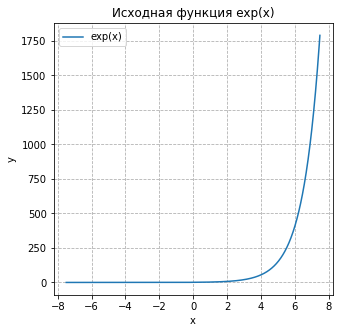

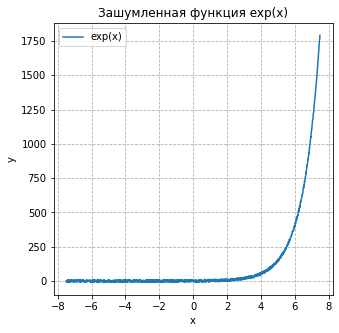

In [15]:
from src import src

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-7.5, 7.5, 0.01)
y = np.exp(x)
noise = [np.random.uniform(-10, 10) for _ in y]
ny = y + noise

def plotexp(x, y, title="exp(x)", labels=None):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    for xi, yi, label in zip(x, y, labels or ['' for _ in x]):
        plt.plot(xi, yi, label=label)
    plt.grid(linestyle='--')
    plt.legend()
    plt.show()

plotexp([x], [y], "Исходная функция exp(x)", ["exp(x)"])
plotexp([x], [ny], "Зашумленная функция exp(x)", ["exp(x)"])


Осуществим сжатие исходного вектора при помощи вейвлетов Хаара. Проведем 7 итераций алгоритма, итоговый вектор будет в $2 ^ 7 = 128$ раз меньше исходного:

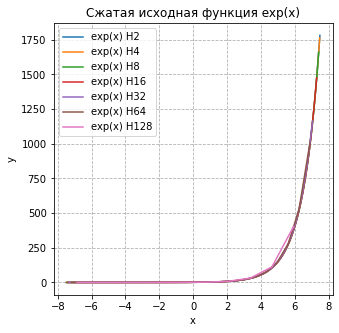

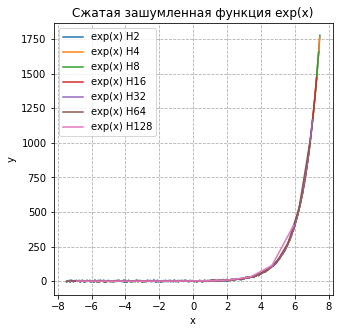

In [19]:
n = 7
fx, fy = src.multi_h_filter(n, x, y)
fx, nfy = src.multi_h_filter(n, x, ny)

plotexp(fx, fy, "Сжатая исходная функция exp(x)", [f"exp(x) H{2 ** (idx + 1)}"for idx, _ in enumerate(y)])
plotexp(fx, nfy, "Сжатая зашумленная функция exp(x)", [f"exp(x) H{2 ** (idx + 1)}"for idx, _ in enumerate(y)])

Рассчитаем standart derivation для полученных зашумленного и незашумленного векторов:

$$\sigma = \sqrt{\dfrac{1}{n}\sum^{n}_{i=0}(y_i - \hat{y}) ^ 2}$$

Где:

$$\hat{y} = \dfrac{1}{n}\sum^{n}_{i=0}y_i$$

In [20]:
print("Среднеквадратичная ошибка для исходного вектора:", np.round(src.st_der(fy[-1]), 3))
print("Среднеквадритичная ошибка для зашумленного вектора", np.round(src.st_der(nfy[-1]), 3))

Среднеквадратичная ошибка для исходного вектора: 116.269
Среднеквадритичная ошибка для зашумленного вектора 116.153


Рассчитаем зашумленность вектора:
$$NRC = 1- \dfrac{y^2}{y'^2}$$

In [21]:
print("Зашумленность для исходного вектора:", np.round(src.nrc(np.exp(fx[-1]), fy[-1]), 3))
print("Зашумленность для зашумленного вектора", np.round(src.nrc(np.exp(fx[-1]), nfy[-1]), 3))

Зашумленность для исходного вектора: 0.874
Зашумленность для зашумленного вектора 0.875


## Вывод

В ходе выполнения работы вейвлеты Хаара были применены для сжатия и фильтрации функции $f(x)=e ^ x$ как с зашумлением, так и без. Судя по полученным коэффициентам зашумления после работы алгоритма не была внесена существенная ошибка. Более того, внесенный шум удалось скомпенсировать при помощи выполненных преобразований.